# Camera Integration Test

End-to-end integration test for the camera system using the **global registry pattern**.

| Step | Purpose |
|------|---------|
| **1. Initialize Driver** | Creates `DriverFactory` and initializes global camera registry (hardware or digital twin) |
| **2. Discover Cameras** | Finds all connected cameras and shows specs (name, resolution) |
| **3. Get Camera Instance** | Gets camera with `auto_connect=True`, displays info |
| **4. Capture Frame** | Takes photo with `CaptureOptions`, displays inline |
| **5. Test Controls** | Gets/sets gain via `get_control()` / `set_control()` |
| **6. Multiple Camera Access** | Verifies singleton pattern, tests second camera if available |
| **7. Cleanup** | Calls `shutdown_registry()` to disconnect all cameras |

In [ ]:
# Package is installed via `pdm install` - no sys.path manipulation needed
from telescope_mcp.drivers.config import DriverConfig, DriverMode, DriverFactory
from telescope_mcp.devices import init_registry, get_registry, shutdown_registry
from telescope_mcp.devices.camera import CaptureOptions

print("✓ Imports successful")

✓ Imports successful


## Step 1: Initialize Driver

In [15]:
# Configure for digital twin mode
#config = DriverConfig(mode=DriverMode.DIGITAL_TWIN)
config = DriverConfig(mode=DriverMode.HARDWARE)
factory = DriverFactory(config)

# Create camera driver
driver = factory.create_camera_driver()
print(f"✓ Created driver: {type(driver).__name__}")

# Initialize registry with driver
init_registry(driver)
registry = get_registry()
print(f"✓ Initialized registry: {registry}")

✓ Created driver: ASICameraDriver
✓ Initialized registry: <CameraRegistry(discovered=0, active=0)>


## Step 2: Discover Cameras

In [7]:
# Discover available cameras
cameras = registry.discover()
print(f"✓ Discovered {len(cameras)} camera(s)")

for cam_id, cam_info in cameras.items():
    print(f"  - {cam_info.name} (ID: {cam_id})")
    print(f"    Max resolution: {cam_info.max_width}x{cam_info.max_height}")

2025-12-24 05:50:20,585 - telescope_mcp.drivers.cameras.asi - INFO - ASI SDK initialized from /home/mark/src/telescope-mcp/src/telescope_mcp/drivers/asi_sdk/x64/libASICamera2.so.1.40
2025-12-24 05:50:21,842 - telescope_mcp.drivers.cameras.asi - INFO - Discovered 2 ASI camera(s)


✓ Discovered 2 camera(s)
  - ZWO ASI120MC-S(Camera) (ID: 0)
    Max resolution: 1280x960
  - ZWO ASI482MC (ID: 1)
    Max resolution: 1920x1080


## Step 3: Get Camera Instance

In [10]:
# Get camera 0 (finder camera)
camera = registry.get(camera_id=0, auto_connect=True)
print(f"✓ Got camera: {camera}")
print(f"  Connected: {camera.is_connected}")

# Get camera info (property, not method)
info = camera.info
print(f"\nCamera Info:")
print(f"  Name: {info.name}")
print(f"  Resolution: {info.max_width}x{info.max_height}")
print(f"  Color: {info.is_color}")
print(f"  Supported bins: {info.supported_bins}")

✓ Got camera: <Camera(ZWO ASI120MC-S(Camera), connected)>
  Connected: True

Camera Info:
  Name: ZWO ASI120MC-S(Camera)
  Resolution: 1280x960
  Color: True
  Supported bins: [1, 2]


## Step 4: Capture Frame

✓ Capture successful
  Format: jpeg
  Size: 41676 bytes
  Dimensions: 1280x960


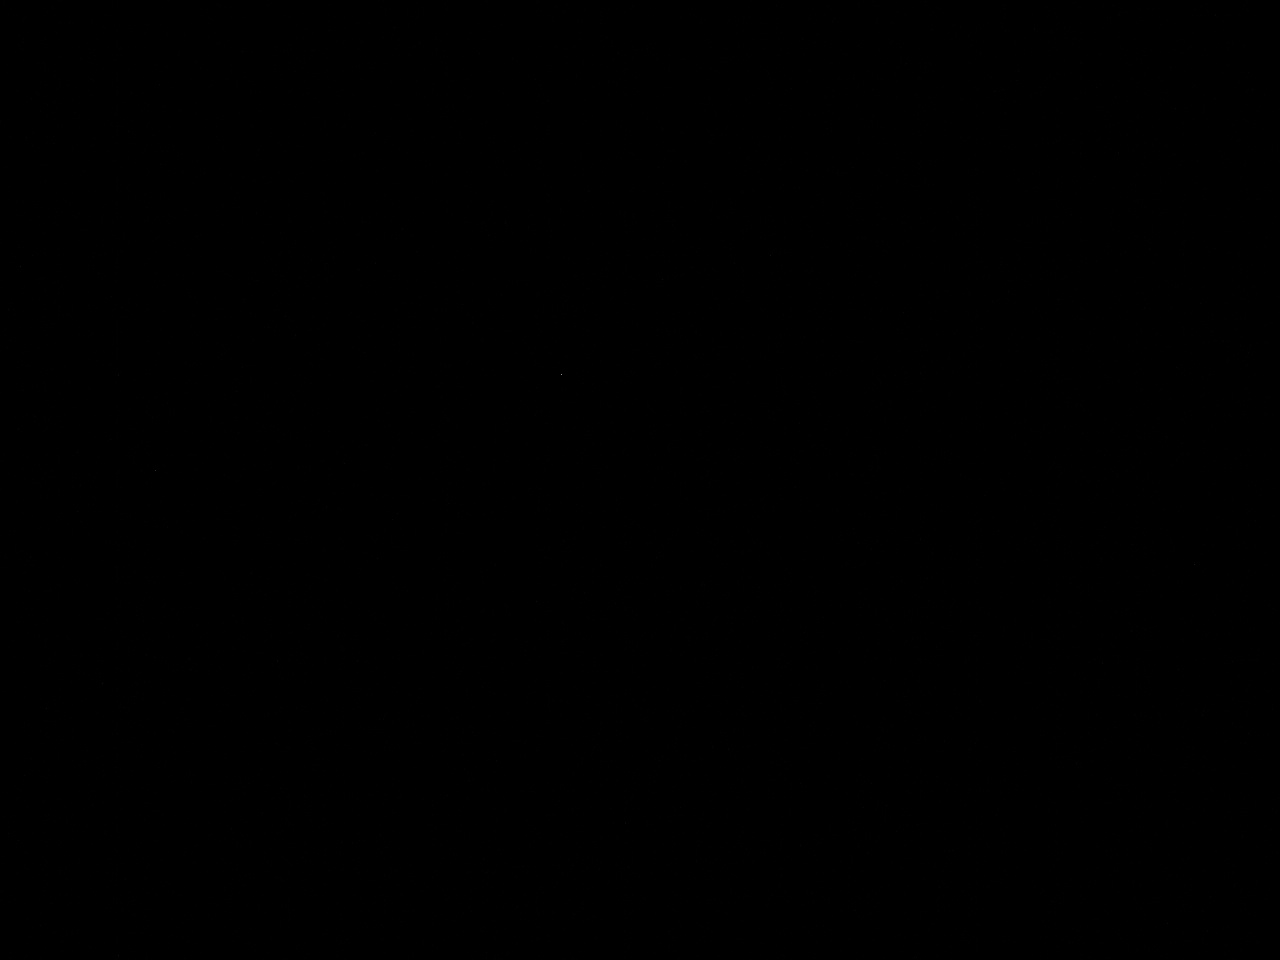

In [12]:
import cv2
import numpy as np
from IPython.display import Image, display

# Capture with default options
options = CaptureOptions(
    exposure_us=100000,  # 100ms
    gain=50
)

result = camera.capture(options)
print(f"✓ Capture successful")
print(f"  Format: {result.format}")
print(f"  Size: {len(result.image_data)} bytes")
print(f"  Dimensions: {result.width}x{result.height}")

# Display image
if result.format == 'jpeg':
    display(Image(result.image_data))
else:
    # Decode RAW8 to display
    img_array = np.frombuffer(result.image_data, dtype=np.uint8)
    img_array = img_array.reshape((result.height, result.width))
    _, jpeg_data = cv2.imencode('.jpg', img_array)
    display(Image(jpeg_data.tobytes()))

## Step 5: Test Camera Controls

In [17]:
# Get control value
gain_info = camera._instance.get_control('Gain')
print(f"Current gain: {gain_info['value']}")

# Set control value
camera._instance.set_control('Gain', value=75)
new_gain_info = camera._instance.get_control('Gain')
print(f"New gain: {new_gain_info['value']}")

# Show all control info
print(f"\nGain control info:")
for key, value in gain_info.items():
    print(f"  {key}: {value}")

Current gain: 50
New gain: 75

Gain control info:
  control: Gain
  value: 50
  auto: False


## Step 6: Test Multiple Camera Access

In [19]:
# Get same camera again - should return cached instance
camera2 = registry.get(camera_id=0)
print(f"Same instance: {camera is camera2}")
print(f"✓ Singleton pattern working correctly")

# Try to get camera 1 if available
if len(cameras) > 1:
    camera_1 = registry.get(camera_id=1, auto_connect=True)
    print(f"\n✓ Got second camera: {camera_1}")
    print(f"  Connected: {camera_1.is_connected}")

Same instance: False
✓ Singleton pattern working correctly

✓ Got second camera: <Camera(ZWO ASI482MC, connected)>
  Connected: True


## Step 7: Cleanup

In [20]:
# Shutdown registry (disconnects all cameras)
shutdown_registry()
print("✓ Registry shutdown complete")

2025-12-24 05:59:42,680 - telescope_mcp.devices.camera - INFO - Disconnecting camera | camera_id=1
2025-12-24 05:59:42,686 - telescope_mcp.drivers.cameras.asi - INFO - Closed ASI camera 1


✓ Registry shutdown complete


## Results

If all cells executed successfully, the camera integration is working correctly:
- ✓ Digital twin driver creates simulated cameras
- ✓ Registry discovers and manages camera instances
- ✓ Camera captures frames with configurable options
- ✓ Camera controls work (get/set)
- ✓ Singleton pattern ensures one instance per camera_id
- ✓ Cleanup properly disconnects cameras